## Installation

In [1]:
!pip install graphviz

## Graph code

In [2]:
from graphviz import Digraph

def trace(root):

    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.value, n.grad), shape='record')

        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## Value class definition

In [3]:
class Value:
    def __init__(self, value,label=None, prev=(), grad=0.0, op=None):
        self.label = label
        self._prev = prev
        self.grad = grad
        self._op = op
        self.value = value
        self._backward = None

    def __repr__(self):
        return f"Value({self.value})"

    def __add__(self, other):
        output = Value(self.value + other.value, prev=(self, other), op='+')
        def backward():
            self.grad += 1.0
            other.grad += 1.0
        output._backward = backward
        return output

    def __sub__(self, other):
        output =  Value(self.value - other.value, prev = (self,other), op='-')
        def backward():
            self.grad += 1.0
            other.grad += -1.0
        output._backward = backward
        return output

    def __mul__(self, other):
        output =  Value(self.value * other.value, prev = (self,other), op='*')
        def backward():
            self.grad = other.value
            other.grad = self.value
        output._backward = backward
        return output

    def __truediv__(self, other):
        output =  Value(self.value / other.value, prev = (self,other), op='/')
        def backward():
            self.grad = 1.0 / other.value
            other.grad = -self.value / (other.value ** 2)
        output._backward = backward
        return output

## Addition trial

In [4]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')

c = a + b

c._backward()

print(a.grad)
print(b.grad)

1.0
1.0


In [6]:
dot = draw_dot(c)
dot.render('graph.gv', view=True)

'graph.gv.svg'

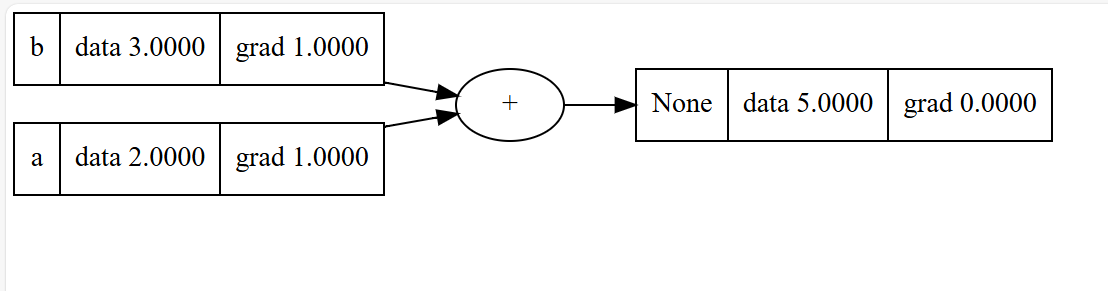

## Subtraction Trial

In [7]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')

c = b - a

c._backward()

print(a.grad)
print(b.grad)

-1.0
1.0


## Multiplication Trial

In [8]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')

c = a * b

c._backward()

print(a.grad)
print(b.grad)

3.0
2.0


## Division Trial

In [9]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')

c = a / b

c._backward()

print(a.grad)
print(b.grad)

0.3333333333333333
-0.2222222222222222


In [13]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')

c = Value(4.0, label='c')

e = a + b
e.label ='e'

f = e * c
f.label = 'f'

g = f / a
g.label = 'g'

e._backward()
f._backward()

print(a.grad)
print(b.grad)
print(c.grad)
print(e.grad)

1.0
1.0
5.0
4.0


In [14]:
dot = draw_dot(f)
dot.render('graph.gv', view=True)

'graph.gv.svg'

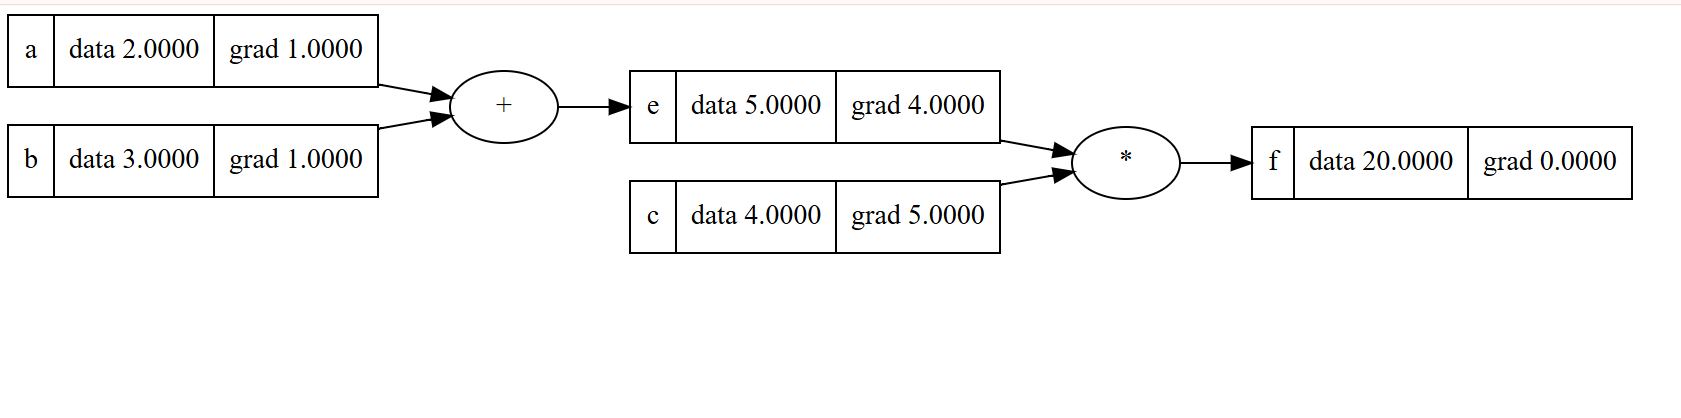